# Kyle Calabro
# DATA 750 - Thesis in Data Science
# 12 August 2021
---

# Notebook Three:
---
## Implementing "Offline Data Augmentation"
---
## Generates CSV files for both the training and test set of data.
## Training file contains both original, unaugmented data as well as augmented data from the training set
## Testing file contains original, unaugmented data from the test set

In [83]:
import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
tf.random.set_random_seed(42)

# Utility Functions
---

In [84]:
# To generate the log-mel sepctrogram values of a given audio file
# Params:
    # audio_data: audio time series
    # sr: target sampling rate

def generate_log_spectrogram(audio_data, sr):
    spectrogram = librosa.feature.melspectrogram(y = audio_data, sr = sr, n_mels = 128, fmax = 8000)
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
    return log_spectrogram

In [85]:
# To generate and display a waveplot of a given audio file
# Params:
    # x: audio time series
    # sr: target sampling rate
    # title: The title of the waveplot
    
def display_waveplot(x, sr, title):
    plt.figure(figsize = (8, 4))
    librosa.display.waveplot(x, sr = sr)
    plt.title(title);

In [86]:
# To generate and display a spectrogram of a given audio file
# Params:
    # x: audio time series
    # sr: target sampling rate
    # title: The title of the spectrogram
    
def display_log_mel_spectrogram(x, sr, title):
    spectrogram = librosa.feature.melspectrogram(y = x, sr = sr, n_mels = 128, fmax = 8000) 
    spectrogram = librosa.power_to_db(spectrogram)

    librosa.display.specshow(spectrogram, y_axis = "mel", fmax = 8000, x_axis = "time");
    plt.title(title)
    plt.colorbar(format = "%+2.0f dB");

# Data Augmentation Functions
---

In [87]:
# To add random noise to the audio file
# Params:
    # data: The data to augment (audio time series)
    
def add_noise(data):
    noise = .05 * np.random.uniform() * np.amax(data)
    data_noise = data.astype("float64") + noise * np.random.normal(size = data.shape[0])
    return data_noise

In [88]:
# To shift the audio in a given audio file left or right by a random value
# Params:
    # data: The data to augment (audio time series)
    
def shift_audio(data):
    return np.roll(data, 1600)

In [89]:
# To stretch a given audio file by a fixed rate (change the speed)
# Params:
    # data: The data to augment (audio time series)
    # rate: The stretch factor (> 1 = signal sped up, < 1 = signal slowed down)
    
def stretch_audio(data, rate = .8):
    return librosa.effects.time_stretch(data, rate)

In [90]:
# To shift the pitch of a waveform up by a major third
# Params:
    # data: The data to augment (audio time series)
    # sr: The audio sampling rate of the data
    
def pitch_majorThird(data, sr):
    return librosa.effects.pitch_shift(data, sr, n_steps = 4)

In [91]:
# To shift the pitch of a waveform down by a tritone
# Params:
    # data: The data to augment (audio time series)
    # sr: The audio sampling rate of the data
def pitch_tritone(data, sr):
        return librosa.effects.pitch_shift(data, sr, n_steps = -6)

In [92]:
# To shift the pitch of a waveform by three quarter-tones
# Params:
    # data: The data to augment (audio time series)
    # sr: The audio sampling rate of the data
    
def pitch_quarter_tone(data, sr):
        # Bins_per_octave -> number of steps per octave
        return librosa.effects.pitch_shift(data, sr, n_steps = 3, bins_per_octave = 24)

# Bringing in the Data
----

In [94]:
audio_df = pd.read_csv("audio_df.csv", usecols = ["Emotion", "path", "Gender", "Actor"])

In [95]:
audio_df.head()

Gender   Emotion  Actor                                               path
0   male  Surprise      1  ./data/audio_files/Actor_01/03-01-08-02-02-01-...
1   male  Surprise      1  ./data/audio_files/Actor_01/03-01-08-01-01-01-...
2   male     Angry      1  ./data/audio_files/Actor_01/03-01-05-01-02-01-...
3   male      Fear      1  ./data/audio_files/Actor_01/03-01-06-01-02-02-...
4   male      Fear      1  ./data/audio_files/Actor_01/03-01-06-02-01-02-...

In [96]:
train_data, test_data = train_test_split(audio_df, test_size = .2, random_state = 42, stratify = audio_df[["Emotion", "Gender", "Actor"]])

In [97]:
train_data.head()

Gender  Emotion  Actor                                               path
774    male  Disgust     13  ./data/audio_files/Actor_13/03-01-07-01-02-01-...
189  female  Disgust      4  ./data/audio_files/Actor_04/03-01-07-01-01-01-...
126    male    Angry      3  ./data/audio_files/Actor_03/03-01-05-01-02-01-...
270    male    Angry      5  ./data/audio_files/Actor_05/03-01-05-01-02-02-...
845    male     Fear     15  ./data/audio_files/Actor_15/03-01-06-02-01-02-...

In [98]:
test_data.head()

Gender  Emotion  Actor  \
1306  female  Disgust     22   
718   female  Disgust     12   
1150  female  Neutral     20   
746     male    Happy     13   
698   female      Sad     12   

                                                   path  
1306  ./data/audio_files/Actor_22/03-01-07-02-02-01-...  
718   ./data/audio_files/Actor_12/03-01-07-02-01-01-...  
1150  ./data/audio_files/Actor_20/03-01-01-01-01-02-...  
746   ./data/audio_files/Actor_13/03-01-03-01-02-01-...  
698   ./data/audio_files/Actor_12/03-01-04-02-02-01-...

In [123]:
train_data.to_csv("train_data_path.csv")

In [124]:
test_data.to_csv("test_data_path.csv")

# Exploratory Data Analysis
---

## Male Neutral
---

In [101]:
data, sr = librosa.load("./data/audio_files/Actor_01/03-01-01-01-01-01-01.wav")

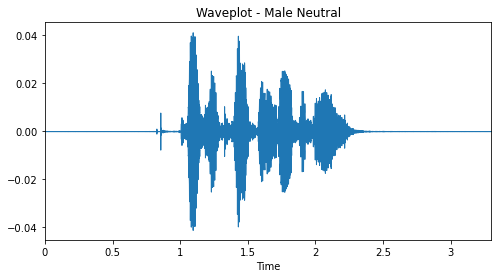

In [102]:
display_waveplot(data, sr, "Waveplot - Male Neutral")

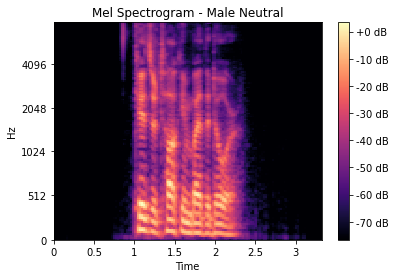

In [103]:
display_log_mel_spectrogram(data, sr, "Mel Spectrogram - Male Neutral")

## Male Neutral - Noise Added
---

In [17]:
noise_data = add_noise(data)

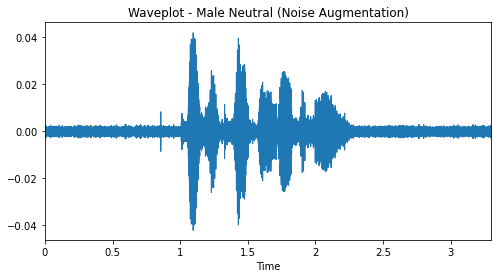

In [18]:
display_waveplot(noise_data, sr, "Waveplot - Male Neutral (Noise Augmentation)")

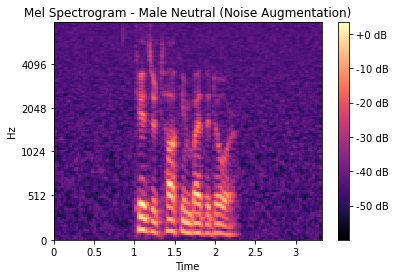

In [19]:
display_log_mel_spectrogram(noise_data, sr, "Mel Spectrogram - Male Neutral (Noise Augmentation)")

## Male Neutral - Shifted
---

In [20]:
shift_data = shift_audio(data)

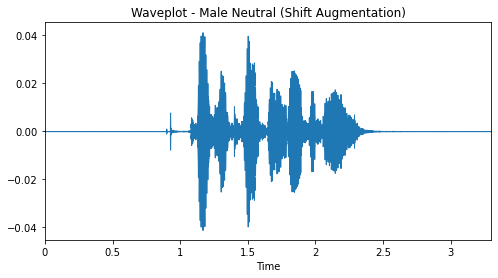

In [21]:
display_waveplot(shift_data, sr, "Waveplot - Male Neutral (Shift Augmentation)")

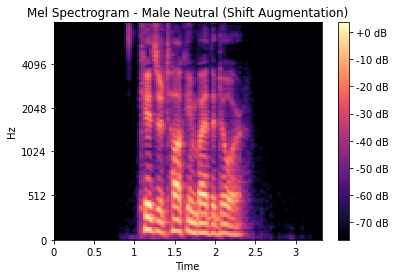

In [22]:
display_log_mel_spectrogram(shift_data, sr, "Mel Spectrogram - Male Neutral (Shift Augmentation)")

## Male Neutral - Stretch Half
---

In [23]:
stretch_half_data = stretch_audio(data, .5)

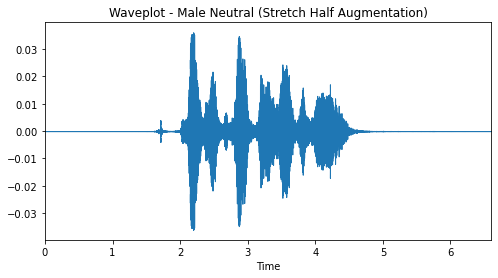

In [24]:
display_waveplot(stretch_half_data, sr, "Waveplot - Male Neutral (Stretch Half Augmentation)")

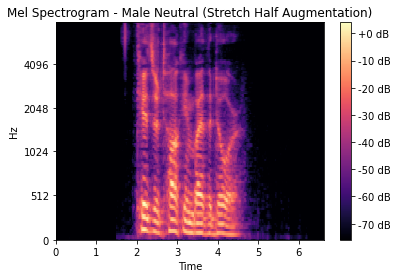

In [25]:
display_log_mel_spectrogram(stretch_half_data, sr, "Mel Spectrogram - Male Neutral (Stretch Half Augmentation)")

## Male Neutral - Stretch Double
---

In [26]:
stretch_double_data = stretch_audio(data, 2)

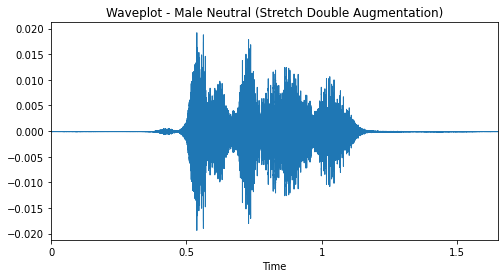

In [27]:
display_waveplot(stretch_double_data, sr, "Waveplot - Male Neutral (Stretch Double Augmentation)")

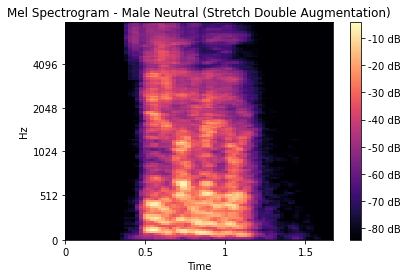

In [28]:
display_log_mel_spectrogram(stretch_double_data, sr, "Mel Spectrogram - Male Neutral (Stretch Double Augmentation)")

## Male Neutral - Stretch by .8
---

In [29]:
stretch_data = stretch_audio(data, .8)

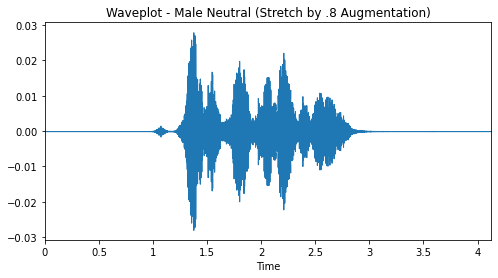

In [30]:
display_waveplot(stretch_data, sr, "Waveplot - Male Neutral (Stretch by .8 Augmentation)")

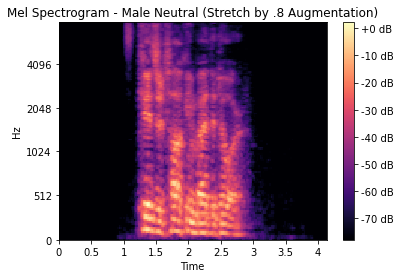

In [31]:
display_log_mel_spectrogram(stretch_data, sr, "Mel Spectrogram - Male Neutral (Stretch by .8 Augmentation)")

## Male Neutral - Stretch by 1.2
---

In [32]:
stretch_data = stretch_audio(data, 1.2)

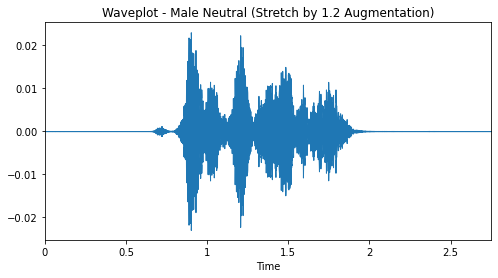

In [33]:
display_waveplot(stretch_data, sr, "Waveplot - Male Neutral (Stretch by 1.2 Augmentation)")

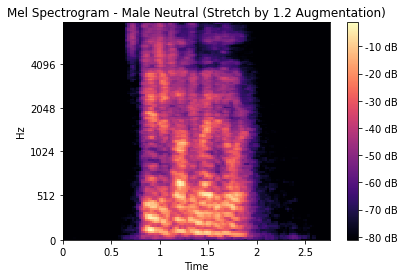

In [34]:
display_log_mel_spectrogram(stretch_data, sr, "Mel Spectrogram - Male Neutral (Stretch by 1.2 Augmentation)")

## Male Neutral - Pitch Major Third 
---

In [104]:
pitch_majorThird_data = pitch_majorThird(data, sr)

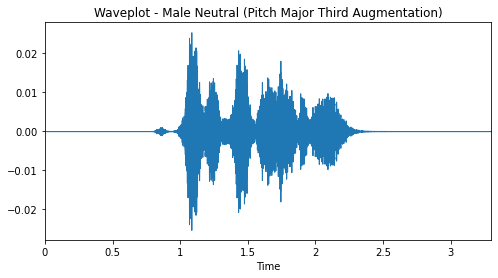

In [36]:
display_waveplot(pitch_majorThird_data, sr, "Waveplot - Male Neutral (Pitch Major Third Augmentation)")

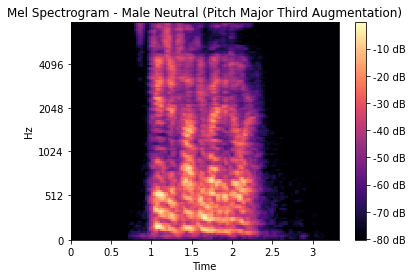

In [37]:
display_log_mel_spectrogram(pitch_majorThird_data, sr, "Mel Spectrogram - Male Neutral (Pitch Major Third Augmentation)")

## Male Neutral - Pitch Tritone
---

In [38]:
pitch_tritone_data = pitch_tritone(data, sr)

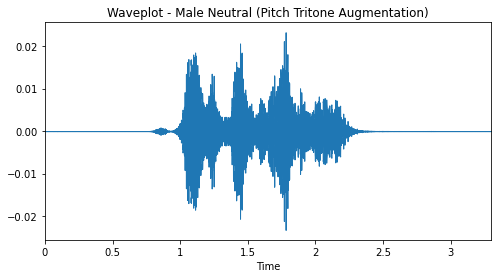

In [39]:
display_waveplot(pitch_tritone_data, sr, "Waveplot - Male Neutral (Pitch Tritone Augmentation)")

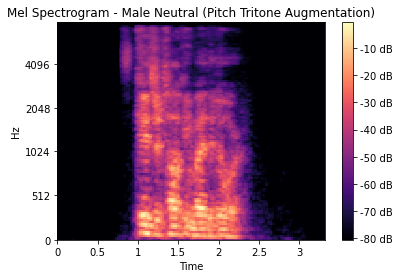

In [40]:
display_log_mel_spectrogram(pitch_tritone_data, sr, "Mel Spectrogram - Male Neutral (Pitch Tritone Augmentation)")

## Male Neutral - Pitch Quarter Tone
---

In [41]:
pitch_quarter_tone_data = pitch_quarter_tone(data, 2)

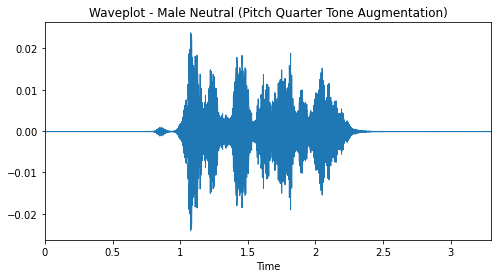

In [42]:
display_waveplot(pitch_quarter_tone_data, sr, "Waveplot - Male Neutral (Pitch Quarter Tone Augmentation)")

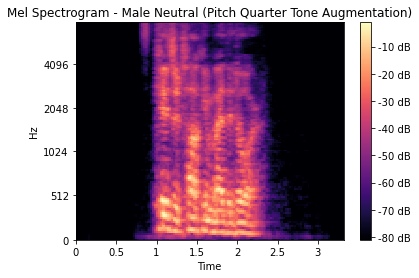

In [43]:
display_log_mel_spectrogram(pitch_quarter_tone_data, sr, "Mel Spectrogram - Male Neutral (Pitch Quarter Tone Augmentation)")

### Examining the waveplots and spectrograms, it appears that noise, shift (albeit by a random value), stretch by a factor of two, 
### and adjusting pitch up by three quarter-tones have the most significant impact on the audio data

# Feature Extraction and Data Augmentation
---
### Iterating over all the audio files, apply all augmentations to the Data.
### Generate a master Dataframe with all Augmented data plus the original data. 

## Augment the training data and generate the log mel spectrogram values
---

In [105]:
train_data.reset_index(drop = True, inplace = True)

In [106]:
# Dataframes to hold the spectrograms of the augmented data
noise_df = pd.DataFrame(columns = ["mel_spectrogram"])
shift_df = pd.DataFrame(columns = ["mel_spectrogram"])
stretch_half_df = pd.DataFrame(columns = ["mel_spectrogram"])
stretch_double_df = pd.DataFrame(columns = ["mel_spectrogram"])
pitch_majorThird_df = pd.DataFrame(columns = ["mel_spectrogram"])
pitch_tritone_df = pd.DataFrame(columns = ["mel_spectrogram"])
pitch_quarter_tone_df = pd.DataFrame(columns = ["mel_spectrogram"])
aug_train_df = pd.DataFrame(columns = ["mel_spectrogram"])

counter = 0

for index, path in enumerate(train_df.path):
    data, sr = librosa.load(path, res_type = "kaiser_fast", duration = 3, sr = 44100, offset = .5)

    # Retrieve the mel-scaled spectrograms for all augmentations, transforming both the y-axis (frequency) to log scale,
    # and the x-axis (color/amplitude) to Decibels, i.e. log scale of amplitudes
    noise_augmentation = add_noise(data)
    shift_augmentation = shift_audio(data)
    stretch_augmentation_half = stretch_audio(data, .8)
    stretch_augmentation_double = stretch_audio(data, 1.2)
    pitch_majorThird_augmentation = pitch_majorThird(data, sr)
    pitch_tritone_augmentation = pitch_tritone(data, sr)
    pitch_quarter_tone_augmentation = pitch_quarter_tone(data, sr)

    # Get the spectrogram of the data augmented with noise
    noise_spectrogram = generate_log_spectrogram(noise_augmentation, sr)
    noise_df.loc[counter] = [noise_spectrogram]

    # Get the spectrogram of the data augmented via shift
    shift_spectrogram = generate_log_spectrogram(shift_augmentation, sr)
    shift_df.loc[counter] = [shift_spectrogram]

    # Get the spectrogram of the data augmented via stretch by half
    stretch_half_spectrogram = generate_log_spectrogram(stretch_augmentation_half, sr)
    stretch_half_df.loc[counter] = [stretch_half_spectrogram]

    # Get the spectrogram of the data augmented via stretch by factor of two
    stretch_double_spectrogram = generate_log_spectrogram(stretch_augmentation_double, sr)
    stretch_double_df.loc[counter] = [stretch_double_spectrogram]

    # Get the spectrogram of the data augmented with pitch (Major Third)
    majorThird_spectrogram = generate_log_spectrogram(pitch_majorThird_augmentation, sr)
    pitch_majorThird_df.loc[counter] = [majorThird_spectrogram]

    # Get the spectrogram of the data augmented with pitch (Tri-tone)
    tritone_spectrogram = generate_log_spectrogram(pitch_tritone_augmentation, sr)
    pitch_tritone_df.loc[counter] = [tritone_spectrogram]

    # Get the spectrogram of the data augmented with pitch (Quarter Tone)
    quartertone_spectrogram = generate_log_spectrogram(pitch_quarter_tone_augmentation, sr)
    pitch_quarter_tone_df.loc[counter] = [quartertone_spectrogram]

    # Get the spectrogram of the original, unaugmented data
    orig_spectrogram = generate_log_spectrogram(data, sr)
    aug_train_df.loc[counter] = [orig_spectrogram]

    counter = counter + 1

In [107]:
print("Length of Augmented DataFrames:")
print("Noise:", len(noise_df))
print("Shift:", len(shift_df))
print("Stretch by Half:", len(stretch_half_df))
print("Stretch by Double:", len(stretch_double_df))
print("Major Third Pitch:", len(pitch_majorThird_df))
print("Tritone Pitch:", len(pitch_tritone_df))
print("Quarter Tone Pitch:", len(pitch_quarter_tone_df))
print("Original Data:", len(aug_train_df))

Length of Augmented DataFrames:
Noise: 1152
Shift: 1152
Stretch by Half: 1152
Stretch by Double: 1152
Major Third Pitch: 1152
Tritone Pitch: 1152
Quarter Tone Pitch: 1152
Original Data: 1152


In [108]:
# Label the augmentation to make selecting certain augmentations a breeze later
noise_df["Augmentation"] = "Noise"
shift_df["Augmentation"] = "Shift"
stretch_half_df["Augmentation"] = "Stretch .8"
stretch_double_df["Augmentation"] = "Stretch 1.2"
pitch_majorThird_df["Augmentation"] = "Pitch Major Third"
pitch_tritone_df["Augmentation"] = "Pitch Tritone"
pitch_quarter_tone_df["Augmentation"] = "Pitch Quarter tone"
aug_train_df["Augmentation"] = "None"

In [110]:
# Build out the master dataframe of augmented data
aug_df = pd.DataFrame(columns = ["Augmentation"])

aug_df = pd.concat([noise_df.Augmentation, train_data, pd.DataFrame(noise_df["mel_spectrogram"].values.tolist())], axis = 1)

aug_df = aug_df.append(pd.concat([shift_df.Augmentation, train_data, pd.DataFrame(shift_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([pitch_majorThird_df.Augmentation, train_data, pd.DataFrame(pitch_majorThird_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([pitch_tritone_df.Augmentation, train_data, pd.DataFrame(pitch_tritone_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([pitch_quarter_tone_df.Augmentation, train_data, pd.DataFrame(pitch_quarter_tone_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([aug_train_df.Augmentation, train_data, pd.DataFrame(aug_train_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([stretch_half_df.Augmentation, train_data, pd.DataFrame(stretch_half_df["mel_spectrogram"].values.tolist())], axis = 1))
aug_df = aug_df.append(pd.concat([stretch_double_df.Augmentation, train_data, pd.DataFrame(stretch_double_df["mel_spectrogram"].values.tolist())], axis = 1))

aug_df = aug_df.fillna(0)
aug_df.drop(columns = "path", inplace = True)

In [111]:
print(len(aug_df))

9216


In [112]:
# Drop the padded data generated from stretching (it's garbage data!)
aug_df = aug_df.iloc[:, :263]

In [113]:
aug_df.head()

Augmentation  Gender  Emotion  Actor          0          1          2  \
0        Noise    male  Disgust     13 -50.270992 -49.346694 -49.822502   
1        Noise  female  Disgust      4 -39.650554 -39.008667 -39.701375   
2        Noise    male    Angry      3 -37.205282 -36.097928 -36.015853   
3        Noise    male    Angry      5 -46.433297 -45.146911 -45.193402   
4        Noise    male     Fear     15 -30.231743 -28.766333 -28.951214   

           3          4          5  ...        249        250        251  \
0 -49.815537 -49.560946 -49.379482  ...   0.000000   0.000000   0.000000   
1 -39.664439 -39.599220 -39.127860  ... -38.561129 -38.783143 -38.862264   
2 -36.027088 -36.490545 -36.713721  ... -36.593853 -36.322970 -35.913771   
3 -45.591403 -44.953065 -45.059758  ... -35.525361 -36.909646 -38.427723   
4 -29.360286 -29.361902 -29.129311  ... -29.686859 -29.133970 -29.522443   

         252        253        254        255        256        257        258  
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
1 -39.299520 -39.424192 -39.217359 -39.518335 -39.640597 -38.951977 -39.540231  
2 -36.037244 -36.094914 -35.603011 -35.208251 -35.657458 -36.039433 -37.443102  
3 -39.670590 -40.742221 -42.371991 -42.823021 -42.016366 -41.280996 -42.799487  
4 -29.996766 -29.805341 -29.437936 -29.308242   0.000000   0.000000   0.000000  

[5 rows x 263 columns]

In [125]:
aug_df.to_csv("aug_train_data.csv")

## Generate the log mel spectrogram values for the testing data
------

In [115]:
test_data.reset_index(drop = True, inplace = True)

In [116]:
# Dataframe to hold the spectrograms of the test data
test_df = pd.DataFrame(columns = ["mel_spectrogram"])
counter = 0

for index, path in enumerate(test_data.path):
    data, sr = librosa.load(path, res_type = "kaiser_fast", duration = 3, sr = 44100, offset = .5)

    # Retrieve the mel-scaled spectrograms, transforming both the y-axis (frequency) to log scale,
    # and the x-axis (color/amplitude) to Decibels, i.e. log scale of amplitudes
    test_data_spectrogram = generate_log_spectrogram(data, sr)
    test_df.loc[counter] = [test_data_spectrogram]

    counter = counter + 1

In [117]:
print("Length of Test Data DataFrame:")
print("Test Data:", len(test_df))

Length of Test Data DataFrame:
Test Data: 288


In [119]:
test_df["Augmentation"] = "None"

In [120]:
# Build out the dataframe of test data
test_data_df = pd.DataFrame(columns = ["Augmentation"])

test_data_df = pd.concat([test_df.Augmentation, test_data, pd.DataFrame(test_df["mel_spectrogram"].values.tolist())], axis = 1)

test_data_df = test_data_df.fillna(0)
test_data_df.drop(columns = "path", inplace = True)

In [121]:
test_data_df.head()

Augmentation  Gender  Emotion  Actor          0          1          2  \
0         None  female  Disgust     22 -64.659958 -65.254463 -66.209488   
1         None  female  Disgust     12 -65.755157 -65.917175 -62.268135   
2         None  female  Neutral     20 -78.726570 -78.726570 -78.726570   
3         None    male    Happy     13 -71.123444 -71.067574 -71.013062   
4         None  female      Sad     12 -59.659962 -59.712753 -59.650646   

           3          4          5  ...        249        250        251  \
0 -66.757156 -66.907104 -67.085808  ... -64.083252 -63.757996 -65.370758   
1 -58.150547 -57.628590 -58.806004  ... -66.896553 -67.250404 -66.518509   
2 -78.726570 -78.726570 -78.726570  ... -78.702095 -78.498978 -78.258232   
3 -71.145126 -71.114044 -70.856827  ...   0.000000   0.000000   0.000000   
4 -59.643253 -59.679802 -59.718342  ... -58.745468 -58.556488 -58.488426   

         252        253        254        255        256        257        258  
0 -65.988335 -66.497498 -66.078773 -65.966904 -65.928604 -66.375893 -66.582321  
1 -66.455315 -66.692474 -66.987755 -67.144867 -67.101929 -67.145737 -66.991982  
2 -78.643265 -78.667511 -78.590645 -78.600418 -78.600021 -78.726570 -78.690475  
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
4 -58.246189 -57.929283 -57.702774 -57.935329 -58.349113 -57.699528 -56.257050  

[5 rows x 263 columns]

In [126]:
test_data_df.to_csv("test_data.csv")